In [1]:
import numpy as np
import pandas as pd

import time
from datetime import datetime

import gensim
import matplotlib.pyplot as plt

import en_nlp_utils
import model_evaluation_utils

In [2]:
# Define default source path
SRC_PATH = "src/"

start_time = datetime.now()
print("Text processing started at {}".format(start_time))

Text processing started at 2024-06-26 01:10:14.472225


In [3]:
# Load dataset
df_review = pd.read_csv(SRC_PATH + "en_hotel_review.csv")

In [4]:
# Check NULL values
en_nlp_utils.check_null(df_review, "df_review")

# Remove rows when "review_cleaned_v1" is NULL
df_review = df_review.dropna(subset=["review_cleaned_v1"]).reset_index(drop=True)

df_review:
source                     0
hotel_id                   0
hotel_name                 0
country                    0
group_name                 0
room_type                  0
stay_length                0
stay_date                  0
review_score               0
review_score_category      0
sentiment                  0
review_date                0
review_title               1
review                     0
review_cleaned_v1        143
dtype: int64
Total rows in df_review: 39974 



## 1) Applying Stratified Sampling

In [5]:
# Function for stratified sampling
def stratified_sample(df, stratify_col, frac):
    return df.groupby(stratify_col, group_keys=False).apply(lambda x: x.sample(frac=frac))

# Convert "stay_date" and "review_date" columns as datetime data type
df_review["stay_date"] = pd.to_datetime(df_review["stay_date"], format="%d/%m/%Y")

# Stratified sampling based on year and sentiment
frac = 0.10  # Sampling ratio
sampled_2022 = stratified_sample(df_review[df_review["stay_date"].dt.year == 2022], "sentiment", frac)
sampled_2023 = stratified_sample(df_review[df_review["stay_date"].dt.year == 2023], "sentiment", frac)
sampled_2024 = stratified_sample(df_review[df_review["stay_date"].dt.year == 2024], "sentiment", frac)

# Merge the sampled data
sampled_data = pd.concat([sampled_2022, sampled_2023, sampled_2024])

In [6]:
# Count number of reviews based on year and sentiment
sampled_sentiment_count = sampled_data.groupby([sampled_data["sentiment"], sampled_data["stay_date"].dt.year]).size().reset_index(name="count")
sampled_sentiment_count2 = sampled_sentiment_count.pivot_table(index="stay_date", columns="sentiment", values="count", 
                                               aggfunc="sum", margins=True, margins_name="Total")
sampled_sentiment_count2.columns.name = None
sampled_sentiment_count2

,negative,positive,Total
stay_date,,,
2022,169,556,725
2023,536,2138,2674
2024,110,474,584
Total,815,3168,3983


## 2) Topic Modeling

### a) Helper functions

In [7]:
# Function to generate bow corpus
def generate_bow_corpus(df, target_text):
    
    documents = [en_nlp_utils.tokenize_sentence_to_words(cleaned_review) for cleaned_review in df[target_text]]
    
    bigram = gensim.models.Phrases(documents, min_count=20, threshold=20, delimiter="_") # higher threshold fewer phrases.
    bigram_model = gensim.models.phrases.Phraser(bigram)
    
    corpus_bigrams = [bigram_model[doc] for doc in documents]
    dictionary = gensim.corpora.Dictionary(corpus_bigrams)
    dictionary.filter_extremes(no_below=20, no_above=0.6)
    bow_corpus = [dictionary.doc2bow(text) for text in corpus_bigrams]
    
    return bow_corpus, corpus_bigrams, dictionary


# Function to calculate all models' coherence scores
def topic_model_coherence_plot(df, df_name, target_text, MODEL_NAMES, START_TOPIC_COUNT, END_TOPIC_COUNT):
    
    overall_coherence_df = pd.DataFrame() # Store each model's coherence scores
    model_topic_info = [] # Store each model's topic information
    
    bow_corpus, corpus_bigrams, dictionary = generate_bow_corpus(df, target_text)
    model_count = 0
    
    for MODEL_NAME in MODEL_NAMES:
        models, coherence_scores = en_nlp_utils.topic_model_coherence_generator(model_name=MODEL_NAME,
                                                                                corpus=bow_corpus,
                                                                                texts=corpus_bigrams,
                                                                                dictionary=dictionary,
                                                                                start_topic_count=START_TOPIC_COUNT,
                                                                                end_topic_count=END_TOPIC_COUNT,
                                                                                step=1,
                                                                                cpus=-1,
                                                                                print_topics=True)

        coherence_df = pd.DataFrame({"Model Name": MODEL_NAME, 
                                     "Number of Topics": range(START_TOPIC_COUNT, END_TOPIC_COUNT + 1, 1), 
                                     "Coherence Score": np.round(coherence_scores, 6),
                                     "df_name": df_name})
        coherence_df.sort_values(by=["Coherence Score"], ascending=False)
        print(coherence_df)
        
        overall_coherence_df = pd.concat([overall_coherence_df, coherence_df], axis=0)
        
        model_topics = []
        for model in models:
            num_topics = model.num_topics
            topics = [[(term, round(wt, 3)) for term, wt in model.show_topic(n, topn=10)] for n in range(num_topics)]
            
            # Determine the number of columns dynamically
            num_terms_per_topic = max(len(topic) for topic in topics)
            
            # Create a DataFrame for topics with dynamic columns and names
            topics_df = pd.DataFrame([[term if len(topic) > i else "" for i, (term, wt) in enumerate(topic)]
                                      for topic in topics],
                                     columns=[f"Term{i+1}" for i in range(num_terms_per_topic)],
                                     index=[f"Topic {t+1}" for t in range(num_topics)]).T
            
            model_topic_info.append({
                "Model Name": MODEL_NAME,
                "Number of Topics": num_topics,
                "Topics": topics_df.to_dict(orient="list"),  # Convert DataFrame to dictionary
                "df_name": df_name
            })
        
        x_ax = range(START_TOPIC_COUNT, END_TOPIC_COUNT + 1, 1)
        y_ax = coherence_scores
        plt.figure(num=model_count, figsize=(15, 12))
        plt.plot(x_ax, y_ax, c="r")
        plt.axhline(y=0.3, c="k", linestyle="--", linewidth=2)
        plt.axhline(y=0.4, c="k", linestyle="--", linewidth=2)
        plt.axhline(y=0.5, c="k", linestyle="--", linewidth=2)
        plt.rcParams["figure.facecolor"] = "white"
        xl = plt.xlabel("Number of Topics")
        yl = plt.ylabel("Coherence Score")

        model_count += 1

    plt.show()
    return overall_coherence_df, model_topic_info


# Function to print best model's topics
def print_best_model_topics(overall_coherence_best_df, model_topic_info_list):
    
    for index, row in overall_coherence_best_df.iterrows():
        model_name = row["Model Name"]
        num_topics = row["Number of Topics"]
        df_name = row["df_name"]
        
        print(f"\nDF NAME: {df_name}\nMODEL: {model_name} - NUMBER OF TOPICS: {num_topics}")
       
        # Find the corresponding model_topic_info
        for model_topic_info in model_topic_info_list:
            for model_info in model_topic_info:
                if (model_info["Model Name"] == model_name and
                    model_info["Number of Topics"] == num_topics and
                    model_info["df_name"] == df_name):
                    
                    topics = model_info["Topics"]
                    for topic_num, terms in topics.items():
                        print(f"\n{topic_num}: {', '.join(terms)}")
                        
                    print("\n----------\n")
                    break

### b) Topic Modeling

In [8]:
# Filter positive and negative reviews and save into different dataframe
df_pos = sampled_data[sampled_data["sentiment"] == "positive"].reset_index(drop=True)
df_neg = sampled_data[sampled_data["sentiment"] == "negative"].reset_index(drop=True)

In [9]:
MODEL_NAMES = ["LSI", "LDA"]
START_TOPIC_COUNT = 2
END_TOPIC_COUNT = 10

df_sets = [df_pos, df_neg]
df_names = ["df_pos", "df_neg"]


DF NAME: df_pos



  0%|                                                                                            | 0/9 [00:00<?, ?it/s]


MODEL: LSI - NUMBER OF TOPICS: 2


 11%|█████████▎                                                                          | 1/9 [00:45<06:04, 45.50s/it]

Topic #1:
0.488*"room" + 0.478*"I" + 0.342*"hotel" + 0.212*"stay" + 0.197*"staff" + 0.177*"good" + 0.160*"location" + 0.139*"clean" + 0.104*"great" + 0.095*"check" + 0.092*"get" + 0.087*"time" + 0.081*"also" + 0.077*"small" + 0.076*"one" + 0.074*"nice" + 0.072*"place" + 0.071*"book" + 0.069*"night" + 0.068*"bed"

Topic #2:
-0.811*"I" + 0.348*"room" + 0.205*"good" + 0.167*"location" + 0.142*"clean" + 0.139*"hotel" + 0.099*"small" + 0.089*"staff" + 0.084*"stay" + 0.076*"great" + -0.069*"check" + 0.067*"nice" + -0.067*"book" + -0.058*"time" + 0.046*"friendly" + 0.046*"food" + -0.043*"god" + 0.043*"meet" + 0.042*"near" + -0.040*"tell"

--------------------------------------------------

MODEL: LSI - NUMBER OF TOPICS: 3


 22%|██████████████████▋                                                                 | 2/9 [01:32<05:26, 46.59s/it]

Topic #1:
0.488*"room" + 0.478*"I" + 0.342*"hotel" + 0.211*"stay" + 0.197*"staff" + 0.177*"good" + 0.160*"location" + 0.138*"clean" + 0.104*"great" + 0.094*"check" + 0.092*"get" + 0.087*"time" + 0.081*"also" + 0.077*"small" + 0.076*"one" + 0.073*"nice" + 0.072*"place" + 0.071*"book" + 0.069*"night" + 0.068*"need"

Topic #2:
-0.811*"I" + 0.348*"room" + 0.205*"good" + 0.169*"location" + 0.143*"clean" + 0.135*"hotel" + 0.098*"small" + 0.090*"stay" + 0.087*"staff" + 0.077*"great" + -0.068*"check" + 0.068*"nice" + -0.067*"book" + -0.057*"time" + 0.046*"friendly" + 0.046*"food" + -0.044*"god" + 0.043*"meet" + 0.041*"near" + -0.040*"tell"

Topic #3:
-0.701*"room" + 0.491*"hotel" + 0.241*"good" + 0.229*"stay" + 0.180*"location" + 0.144*"staff" + -0.092*"small" + 0.078*"great" + 0.067*"breakfast" + 0.066*"singapore" + 0.063*"place" + 0.053*"friendly" + 0.049*"near" + -0.047*"I" + -0.045*"clean" + 0.044*"facility" + 0.042*"around" + 0.038*"area" + 0.037*"many" + 0.036*"food"

-------------------

 33%|████████████████████████████                                                        | 3/9 [02:21<04:44, 47.36s/it]

Topic #1:
0.488*"room" + 0.478*"I" + 0.344*"hotel" + 0.210*"stay" + 0.197*"staff" + 0.177*"good" + 0.159*"location" + 0.138*"clean" + 0.103*"great" + 0.094*"check" + 0.092*"get" + 0.087*"time" + 0.081*"also" + 0.077*"small" + 0.075*"one" + 0.074*"nice" + 0.071*"place" + 0.071*"book" + 0.069*"night" + 0.068*"need"

Topic #2:
-0.809*"I" + 0.344*"room" + 0.215*"good" + 0.175*"location" + 0.145*"clean" + 0.121*"hotel" + 0.098*"small" + 0.093*"stay" + 0.090*"staff" + 0.082*"great" + 0.068*"nice" + -0.067*"check" + -0.067*"book" + -0.057*"time" + 0.048*"friendly" + 0.046*"food" + -0.044*"god" + 0.043*"meet" + 0.042*"near" + -0.040*"tell"

Topic #3:
-0.709*"room" + 0.443*"hotel" + 0.305*"good" + 0.212*"location" + 0.204*"stay" + 0.153*"staff" + -0.091*"small" + 0.083*"great" + 0.072*"place" + 0.066*"breakfast" + 0.060*"singapore" + 0.056*"friendly" + 0.055*"near" + 0.046*"facility" + 0.042*"meet" + 0.040*"food" + 0.037*"area" + 0.037*"price" + 0.036*"around" + 0.035*"nice"

Topic #4:
0.605*"g

 44%|█████████████████████████████████████▎                                              | 4/9 [03:14<04:08, 49.64s/it]

Topic #1:
0.488*"room" + 0.479*"I" + 0.341*"hotel" + 0.211*"stay" + 0.197*"staff" + 0.177*"good" + 0.160*"location" + 0.139*"clean" + 0.103*"great" + 0.094*"check" + 0.092*"get" + 0.087*"time" + 0.081*"also" + 0.077*"small" + 0.075*"one" + 0.074*"nice" + 0.072*"place" + 0.070*"book" + 0.069*"night" + 0.068*"bed"

Topic #2:
-0.813*"I" + 0.341*"room" + 0.207*"good" + 0.169*"location" + 0.160*"hotel" + 0.139*"clean" + 0.097*"small" + 0.084*"staff" + 0.082*"stay" + 0.076*"great" + -0.067*"check" + 0.067*"nice" + -0.063*"book" + -0.056*"time" + 0.045*"friendly" + 0.045*"food" + 0.041*"meet" + 0.041*"near" + 0.039*"close" + -0.039*"tell"

Topic #3:
-0.696*"room" + 0.532*"hotel" + 0.255*"good" + 0.179*"location" + 0.179*"stay" + 0.130*"staff" + -0.093*"small" + 0.062*"great" + 0.061*"singapore" + 0.058*"breakfast" + 0.053*"place" + 0.050*"near" + 0.048*"friendly" + -0.046*"clean" + 0.044*"facility" + 0.035*"food" + 0.035*"price" + 0.035*"meet" + 0.033*"around" + -0.033*"request"

Topic #4:
-0

 56%|██████████████████████████████████████████████▋                                     | 5/9 [04:08<03:25, 51.35s/it]

Topic #1:
0.488*"room" + 0.479*"I" + 0.341*"hotel" + 0.211*"stay" + 0.197*"staff" + 0.177*"good" + 0.160*"location" + 0.139*"clean" + 0.103*"great" + 0.094*"check" + 0.092*"get" + 0.087*"time" + 0.081*"also" + 0.077*"small" + 0.075*"one" + 0.074*"nice" + 0.072*"place" + 0.070*"book" + 0.069*"night" + 0.068*"bed"

Topic #2:
-0.813*"I" + 0.341*"room" + 0.205*"good" + 0.170*"location" + 0.160*"hotel" + 0.140*"clean" + 0.096*"small" + 0.087*"staff" + 0.079*"stay" + 0.076*"great" + 0.067*"nice" + -0.066*"check" + -0.063*"book" + -0.056*"time" + 0.046*"friendly" + 0.045*"food" + 0.041*"meet" + 0.041*"near" + 0.039*"close" + -0.039*"tell"

Topic #3:
-0.697*"room" + 0.530*"hotel" + 0.246*"good" + 0.195*"stay" + 0.178*"location" + 0.131*"staff" + -0.094*"small" + 0.067*"great" + 0.061*"singapore" + 0.057*"breakfast" + 0.056*"place" + 0.049*"friendly" + 0.049*"near" + -0.044*"clean" + 0.043*"facility" + 0.035*"price" + 0.035*"food" + -0.034*"check" + 0.033*"meet" + -0.033*"request"

Topic #4:
-0

 67%|████████████████████████████████████████████████████████                            | 6/9 [05:01<02:35, 51.77s/it]

Topic #1:
0.488*"room" + 0.479*"I" + 0.341*"hotel" + 0.211*"stay" + 0.197*"staff" + 0.177*"good" + 0.159*"location" + 0.139*"clean" + 0.103*"great" + 0.094*"check" + 0.092*"get" + 0.087*"time" + 0.081*"also" + 0.077*"small" + 0.076*"one" + 0.074*"nice" + 0.072*"place" + 0.070*"book" + 0.069*"night" + 0.068*"bed"

Topic #2:
-0.813*"I" + 0.342*"room" + 0.203*"good" + 0.173*"location" + 0.159*"hotel" + 0.140*"clean" + 0.096*"small" + 0.084*"staff" + 0.083*"stay" + 0.078*"great" + 0.067*"nice" + -0.066*"check" + -0.062*"book" + -0.056*"time" + 0.046*"friendly" + 0.045*"food" + 0.042*"meet" + 0.042*"near" + 0.039*"close" + -0.039*"tell"

Topic #3:
-0.697*"room" + 0.531*"hotel" + 0.250*"good" + 0.189*"stay" + 0.171*"location" + 0.138*"staff" + -0.094*"small" + 0.063*"great" + 0.059*"singapore" + 0.059*"breakfast" + 0.057*"place" + 0.051*"friendly" + 0.048*"near" + -0.044*"clean" + 0.043*"facility" + 0.035*"price" + -0.034*"check" + 0.034*"food" + -0.033*"I" + -0.033*"request"

Topic #4:
-0.6

 78%|█████████████████████████████████████████████████████████████████▎                  | 7/9 [05:54<01:44, 52.13s/it]

Topic #1:
0.488*"room" + 0.479*"I" + 0.341*"hotel" + 0.211*"stay" + 0.197*"staff" + 0.177*"good" + 0.160*"location" + 0.139*"clean" + 0.104*"great" + 0.094*"check" + 0.092*"get" + 0.087*"time" + 0.080*"also" + 0.077*"small" + 0.075*"one" + 0.073*"nice" + 0.072*"place" + 0.070*"book" + 0.069*"night" + 0.068*"bed"

Topic #2:
-0.813*"I" + 0.342*"room" + 0.204*"good" + 0.171*"location" + 0.158*"hotel" + 0.141*"clean" + 0.097*"small" + 0.084*"staff" + 0.084*"stay" + 0.076*"great" + 0.067*"nice" + -0.066*"check" + -0.062*"book" + -0.055*"time" + 0.045*"friendly" + 0.045*"food" + 0.042*"meet" + 0.042*"near" + 0.039*"close" + -0.039*"tell"

Topic #3:
-0.695*"room" + 0.532*"hotel" + 0.249*"good" + 0.188*"stay" + 0.176*"location" + 0.138*"staff" + -0.095*"small" + 0.066*"great" + 0.059*"singapore" + 0.058*"breakfast" + 0.054*"place" + 0.051*"friendly" + 0.047*"near" + -0.045*"clean" + 0.043*"facility" + 0.035*"price" + -0.034*"check" + 0.034*"food" + -0.033*"request" + -0.032*"I"

Topic #4:
-0.6

 89%|██████████████████████████████████████████████████████████████████████████▋         | 8/9 [06:47<00:52, 52.61s/it]

Topic #1:
0.488*"room" + 0.479*"I" + 0.341*"hotel" + 0.211*"stay" + 0.197*"staff" + 0.177*"good" + 0.160*"location" + 0.139*"clean" + 0.103*"great" + 0.094*"check" + 0.092*"get" + 0.087*"time" + 0.080*"also" + 0.077*"small" + 0.075*"one" + 0.073*"nice" + 0.072*"place" + 0.070*"book" + 0.069*"night" + 0.068*"bed"

Topic #2:
-0.813*"I" + 0.342*"room" + 0.204*"good" + 0.171*"location" + 0.158*"hotel" + 0.139*"clean" + 0.097*"small" + 0.084*"staff" + 0.084*"stay" + 0.077*"great" + 0.067*"nice" + -0.066*"check" + -0.061*"book" + -0.055*"time" + 0.045*"friendly" + 0.045*"food" + 0.042*"meet" + 0.041*"near" + 0.039*"close" + -0.039*"tell"

Topic #3:
-0.695*"room" + 0.532*"hotel" + 0.250*"good" + 0.188*"stay" + 0.176*"location" + 0.138*"staff" + -0.095*"small" + 0.066*"great" + 0.059*"singapore" + 0.059*"breakfast" + 0.054*"place" + 0.051*"friendly" + 0.047*"near" + -0.046*"clean" + 0.043*"facility" + 0.035*"price" + -0.034*"check" + 0.034*"food" + -0.033*"request" + -0.033*"I"

Topic #4:
-0.6

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [07:41<00:00, 51.30s/it]


Topic #1:
0.488*"room" + 0.479*"I" + 0.341*"hotel" + 0.211*"stay" + 0.197*"staff" + 0.177*"good" + 0.160*"location" + 0.139*"clean" + 0.103*"great" + 0.094*"check" + 0.092*"get" + 0.087*"time" + 0.080*"also" + 0.077*"small" + 0.075*"one" + 0.073*"nice" + 0.072*"place" + 0.070*"book" + 0.069*"night" + 0.068*"bed"

Topic #2:
-0.813*"I" + 0.342*"room" + 0.204*"good" + 0.171*"location" + 0.158*"hotel" + 0.138*"clean" + 0.097*"small" + 0.085*"staff" + 0.084*"stay" + 0.077*"great" + 0.067*"nice" + -0.066*"check" + -0.061*"book" + -0.055*"time" + 0.045*"friendly" + 0.045*"food" + 0.042*"meet" + 0.041*"near" + 0.039*"close" + -0.039*"tell"

Topic #3:
-0.693*"room" + 0.535*"hotel" + 0.248*"good" + 0.188*"stay" + 0.176*"location" + 0.138*"staff" + -0.093*"small" + 0.069*"great" + 0.059*"singapore" + 0.058*"breakfast" + 0.054*"place" + 0.051*"friendly" + -0.051*"clean" + 0.047*"near" + 0.043*"facility" + -0.036*"check" + 0.035*"food" + 0.034*"price" + -0.033*"request" + 0.033*"around"

Topic #4:


  0%|                                                                                            | 0/9 [00:00<?, ?it/s]


MODEL: LDA - NUMBER OF TOPICS: 2


 11%|█████████▎                                                                          | 1/9 [00:06<00:49,  6.17s/it]

Topic #1:
0.055*"room" + 0.030*"good" + 0.028*"hotel" + 0.024*"great" + 0.021*"location" + 0.018*"clean" + 0.017*"I" + 0.014*"staff" + 0.014*"nice" + 0.011*"stay" + 0.011*"need" + 0.009*"check" + 0.009*"bathroom" + 0.008*"food" + 0.008*"near" + 0.008*"get" + 0.008*"breakfast" + 0.008*"place" + 0.007*"area" + 0.007*"meet"

Topic #2:
0.037*"room" + 0.036*"hotel" + 0.035*"I" + 0.031*"stay" + 0.030*"staff" + 0.027*"location" + 0.024*"good" + 0.018*"clean" + 0.011*"place" + 0.010*"friendly" + 0.010*"small" + 0.009*"time" + 0.008*"service" + 0.008*"singapore" + 0.008*"nice" + 0.007*"restaurant" + 0.007*"near" + 0.007*"like" + 0.007*"meet" + 0.007*"breakfast"

--------------------------------------------------

MODEL: LDA - NUMBER OF TOPICS: 3


 22%|██████████████████▋                                                                 | 2/9 [00:11<00:40,  5.83s/it]

Topic #1:
0.056*"room" + 0.029*"hotel" + 0.028*"location" + 0.028*"stay" + 0.025*"I" + 0.024*"staff" + 0.023*"clean" + 0.022*"great" + 0.020*"good" + 0.014*"nice" + 0.011*"small" + 0.010*"place" + 0.010*"friendly" + 0.008*"time" + 0.008*"night" + 0.008*"need" + 0.007*"well" + 0.007*"check" + 0.007*"food" + 0.006*"near"

Topic #2:
0.040*"hotel" + 0.034*"room" + 0.032*"I" + 0.019*"good" + 0.017*"location" + 0.017*"staff" + 0.012*"water" + 0.010*"breakfast" + 0.010*"bed" + 0.009*"check" + 0.009*"also" + 0.008*"like" + 0.008*"give" + 0.008*"one" + 0.008*"clean" + 0.008*"bathroom" + 0.008*"book" + 0.008*"food" + 0.007*"get" + 0.007*"stay"

Topic #3:
0.053*"good" + 0.035*"hotel" + 0.027*"I" + 0.026*"staff" + 0.024*"room" + 0.024*"stay" + 0.023*"location" + 0.016*"clean" + 0.016*"near" + 0.015*"meet" + 0.013*"place" + 0.010*"service" + 0.010*"singapore" + 0.009*"get" + 0.009*"quite" + 0.009*"food" + 0.008*"breakfast" + 0.006*"close" + 0.006*"everything" + 0.006*"overall"

--------------------

 33%|████████████████████████████                                                        | 3/9 [00:16<00:32,  5.47s/it]

Topic #1:
0.064*"room" + 0.028*"staff" + 0.027*"good" + 0.023*"clean" + 0.023*"stay" + 0.021*"I" + 0.017*"location" + 0.015*"small" + 0.014*"friendly" + 0.013*"hotel" + 0.012*"near" + 0.011*"nice" + 0.011*"bed" + 0.010*"check" + 0.010*"one" + 0.010*"night" + 0.008*"book" + 0.007*"get" + 0.007*"also" + 0.007*"service"

Topic #2:
0.047*"good" + 0.045*"location" + 0.036*"hotel" + 0.030*"room" + 0.025*"staff" + 0.025*"great" + 0.021*"stay" + 0.019*"clean" + 0.017*"place" + 0.016*"nice" + 0.011*"price" + 0.009*"food" + 0.009*"facility" + 0.009*"need" + 0.008*"meet" + 0.008*"breakfast" + 0.008*"I" + 0.008*"restaurant" + 0.007*"helpful" + 0.007*"around"

Topic #3:
0.067*"I" + 0.046*"hotel" + 0.037*"room" + 0.021*"staff" + 0.016*"clean" + 0.015*"stay" + 0.014*"good" + 0.010*"place" + 0.010*"small" + 0.009*"singapore" + 0.009*"time" + 0.008*"location" + 0.008*"also" + 0.008*"one" + 0.008*"bit" + 0.008*"really" + 0.007*"like" + 0.007*"well" + 0.007*"quite" + 0.007*"meet"

Topic #4:
0.048*"room" 

 44%|█████████████████████████████████████▎                                              | 4/9 [00:21<00:26,  5.27s/it]

Topic #1:
0.031*"room" + 0.028*"good" + 0.027*"hotel" + 0.022*"location" + 0.018*"small" + 0.018*"nice" + 0.017*"restaurant" + 0.016*"stay" + 0.016*"staff" + 0.015*"food" + 0.014*"many" + 0.013*"check" + 0.011*"place" + 0.011*"locate" + 0.010*"nearby" + 0.010*"bit" + 0.010*"I" + 0.010*"facility" + 0.009*"chinatown" + 0.009*"value_money"

Topic #2:
0.049*"I" + 0.033*"room" + 0.032*"staff" + 0.028*"hotel" + 0.025*"good" + 0.023*"stay" + 0.018*"great" + 0.016*"location" + 0.012*"clean" + 0.011*"breakfast" + 0.010*"place" + 0.008*"get" + 0.008*"helpful" + 0.008*"well" + 0.008*"go" + 0.008*"like" + 0.008*"really" + 0.007*"friendly" + 0.007*"bathroom" + 0.007*"need"

Topic #3:
0.074*"room" + 0.041*"hotel" + 0.028*"stay" + 0.026*"good" + 0.025*"clean" + 0.021*"I" + 0.018*"location" + 0.014*"small" + 0.012*"staff" + 0.010*"nice" + 0.010*"night" + 0.009*"one" + 0.009*"time" + 0.008*"get" + 0.008*"bed" + 0.007*"check" + 0.007*"spacious" + 0.007*"great" + 0.006*"come" + 0.006*"water"

Topic #4:
0

 56%|██████████████████████████████████████████████▋                                     | 5/9 [00:26<00:20,  5.10s/it]

Topic #1:
0.043*"room" + 0.024*"bed" + 0.024*"check" + 0.021*"staff" + 0.020*"hotel" + 0.019*"near" + 0.017*"small" + 0.016*"also" + 0.015*"nice" + 0.014*"night" + 0.013*"good" + 0.013*"I" + 0.012*"many" + 0.011*"early" + 0.011*"time" + 0.011*"location" + 0.011*"bathroom" + 0.009*"even" + 0.009*"stay" + 0.009*"one"

Topic #2:
0.058*"room" + 0.030*"stay" + 0.029*"hotel" + 0.022*"great" + 0.020*"staff" + 0.016*"I" + 0.016*"location" + 0.015*"good" + 0.014*"clean" + 0.012*"food" + 0.011*"small" + 0.011*"close" + 0.010*"also" + 0.010*"night" + 0.010*"meet" + 0.010*"breakfast" + 0.009*"pool" + 0.009*"area" + 0.008*"one" + 0.007*"facility"

Topic #3:
0.051*"hotel" + 0.045*"room" + 0.034*"I" + 0.020*"staff" + 0.018*"stay" + 0.018*"good" + 0.016*"location" + 0.015*"nice" + 0.014*"place" + 0.011*"great" + 0.010*"food" + 0.010*"clean" + 0.009*"convenient" + 0.008*"next" + 0.008*"like" + 0.008*"one" + 0.008*"singapore" + 0.007*"near" + 0.007*"need" + 0.007*"service"

Topic #4:
0.053*"I" + 0.040*"

 67%|████████████████████████████████████████████████████████                            | 6/9 [00:32<00:16,  5.35s/it]

Topic #1:
0.056*"room" + 0.043*"location" + 0.038*"good" + 0.024*"hotel" + 0.024*"clean" + 0.023*"nice" + 0.017*"water" + 0.016*"near" + 0.015*"staff" + 0.015*"I" + 0.014*"meet" + 0.012*"bathroom" + 0.010*"like" + 0.010*"even" + 0.008*"walk" + 0.008*"bed" + 0.008*"small" + 0.008*"bad" + 0.008*"price" + 0.007*"give"

Topic #2:
0.055*"hotel" + 0.050*"good" + 0.034*"room" + 0.033*"staff" + 0.031*"I" + 0.028*"location" + 0.025*"clean" + 0.018*"stay" + 0.015*"place" + 0.013*"service" + 0.012*"singapore" + 0.012*"near" + 0.011*"friendly" + 0.011*"food" + 0.010*"great" + 0.009*"recommend" + 0.008*"nice" + 0.008*"comfortable" + 0.008*"also" + 0.007*"breakfast"

Topic #3:
0.042*"I" + 0.036*"room" + 0.031*"hotel" + 0.026*"staff" + 0.022*"check" + 0.018*"good" + 0.017*"clean" + 0.016*"location" + 0.012*"stay" + 0.012*"great" + 0.011*"breakfast" + 0.010*"book" + 0.010*"time" + 0.009*"bed" + 0.009*"price" + 0.008*"helpful" + 0.008*"like" + 0.007*"go" + 0.007*"view" + 0.007*"friendly"

Topic #4:
0.0

 78%|█████████████████████████████████████████████████████████████████▎                  | 7/9 [00:37<00:10,  5.33s/it]

Topic #1:
0.095*"good" + 0.066*"location" + 0.048*"great" + 0.035*"hotel" + 0.023*"near" + 0.022*"stay" + 0.020*"love" + 0.019*"service" + 0.018*"value_money" + 0.018*"enjoy" + 0.017*"I" + 0.015*"time" + 0.015*"room" + 0.012*"chinatown" + 0.011*"nice" + 0.011*"environment" + 0.010*"next" + 0.010*"accommodation" + 0.010*"definitely" + 0.010*"view"

Topic #2:
0.073*"room" + 0.054*"clean" + 0.027*"staff" + 0.021*"small" + 0.019*"good" + 0.019*"hotel" + 0.018*"stay" + 0.017*"bed" + 0.016*"well" + 0.015*"location" + 0.013*"service" + 0.012*"near" + 0.012*"price" + 0.011*"quite" + 0.011*"space" + 0.011*"need" + 0.010*"nice" + 0.010*"helpful" + 0.010*"iron" + 0.010*"everything"

Topic #3:
0.061*"room" + 0.038*"hotel" + 0.029*"I" + 0.028*"good" + 0.020*"staff" + 0.017*"stay" + 0.017*"location" + 0.015*"clean" + 0.011*"small" + 0.010*"time" + 0.009*"also" + 0.009*"one" + 0.008*"nice" + 0.008*"check" + 0.008*"need" + 0.008*"water" + 0.008*"floor" + 0.007*"like" + 0.007*"close" + 0.007*"door"

To

 89%|██████████████████████████████████████████████████████████████████████████▋         | 8/9 [00:42<00:05,  5.20s/it]

Topic #1:
0.044*"good" + 0.044*"hotel" + 0.039*"location" + 0.034*"room" + 0.023*"price" + 0.022*"nice" + 0.019*"meet" + 0.019*"food" + 0.018*"clean" + 0.017*"place" + 0.017*"stay" + 0.017*"small" + 0.014*"near" + 0.014*"staff" + 0.014*"need" + 0.012*"breakfast" + 0.010*"quite" + 0.008*"bathroom" + 0.008*"restaurant" + 0.008*"convenient"

Topic #2:
0.054*"hotel" + 0.054*"location" + 0.028*"room" + 0.027*"staff" + 0.023*"good" + 0.019*"great" + 0.015*"convenient" + 0.015*"near" + 0.015*"many" + 0.014*"food" + 0.014*"meet_station" + 0.014*"clean" + 0.014*"station" + 0.013*"stay" + 0.012*"around" + 0.012*"bus" + 0.011*"also" + 0.010*"boris" + 0.009*"area" + 0.009*"walk"

Topic #3:
0.048*"room" + 0.039*"location" + 0.031*"clean" + 0.026*"great" + 0.017*"near" + 0.016*"close" + 0.015*"staff" + 0.015*"perfect" + 0.015*"get" + 0.014*"good" + 0.014*"meet" + 0.014*"value_money" + 0.014*"facility" + 0.014*"stay" + 0.013*"hotel" + 0.011*"bit" + 0.010*"locate" + 0.009*"nice" + 0.009*"lot" + 0.009*

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:47<00:00,  5.27s/it]

Topic #1:
0.050*"hotel" + 0.044*"I" + 0.038*"stay" + 0.026*"room" + 0.019*"staff" + 0.017*"clean" + 0.016*"time" + 0.014*"really" + 0.013*"location" + 0.012*"bathroom" + 0.012*"come" + 0.011*"bed" + 0.011*"like" + 0.010*"next" + 0.009*"good" + 0.009*"also" + 0.008*"nice" + 0.008*"amazing" + 0.007*"need" + 0.007*"singapore"

Topic #2:
0.056*"room" + 0.049*"hotel" + 0.029*"staff" + 0.025*"good" + 0.021*"friendly" + 0.019*"stay" + 0.019*"location" + 0.015*"I" + 0.013*"clean" + 0.013*"nice" + 0.012*"area" + 0.011*"close" + 0.011*"one" + 0.010*"door" + 0.010*"floor" + 0.009*"small" + 0.009*"breakfast" + 0.009*"singapore" + 0.008*"also" + 0.008*"near"

Topic #3:
0.064*"I" + 0.051*"room" + 0.023*"hotel" + 0.019*"stay" + 0.018*"location" + 0.016*"good" + 0.015*"staff" + 0.013*"get" + 0.013*"book" + 0.012*"place" + 0.011*"clean" + 0.010*"near" + 0.009*"one" + 0.009*"view" + 0.008*"like" + 0.008*"also" + 0.008*"city" + 0.008*"night" + 0.007*"need" + 0.007*"would"

Topic #4:
0.036*"I" + 0.033*"ho

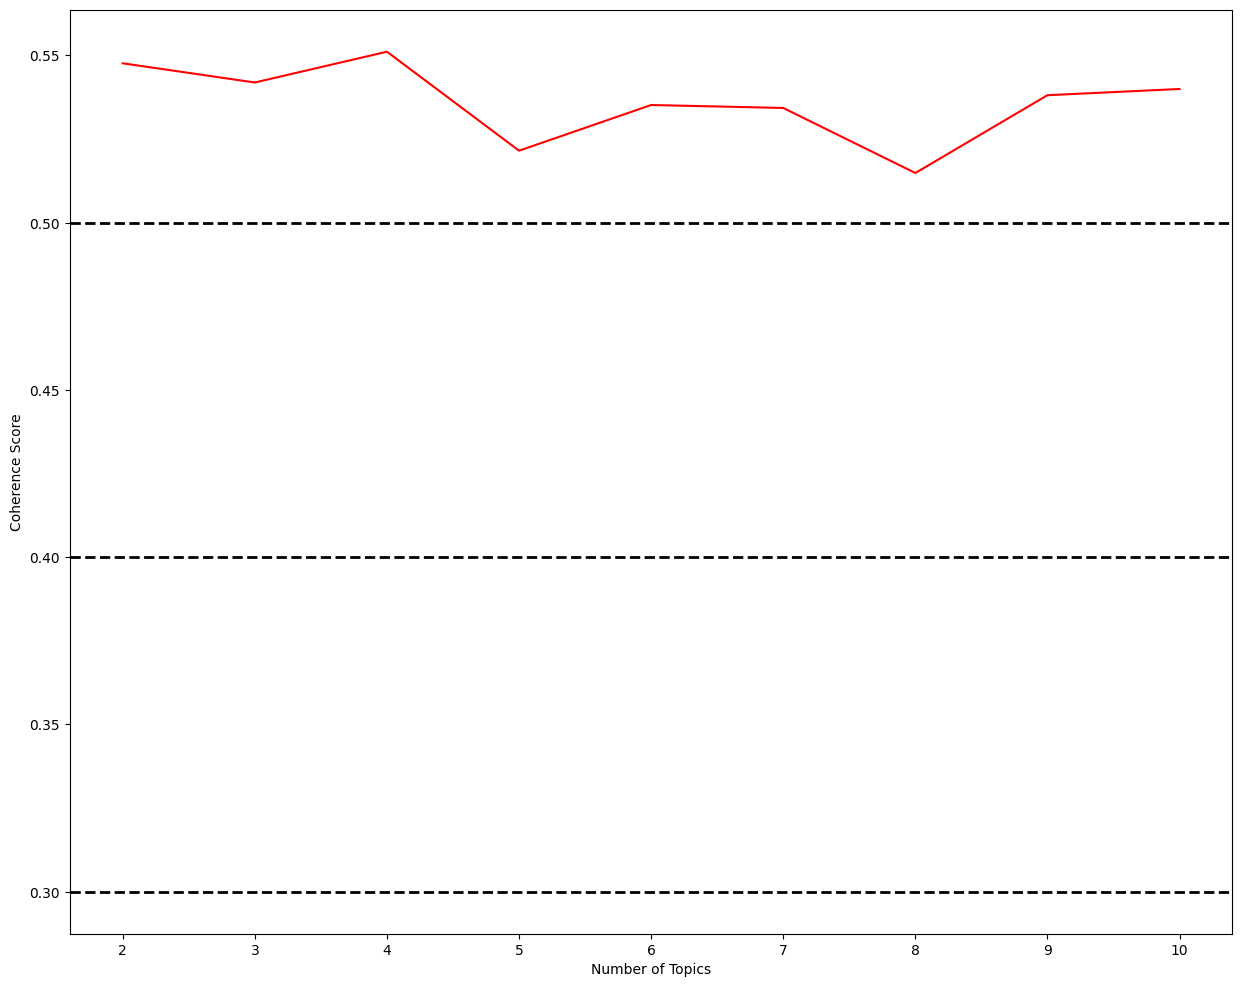

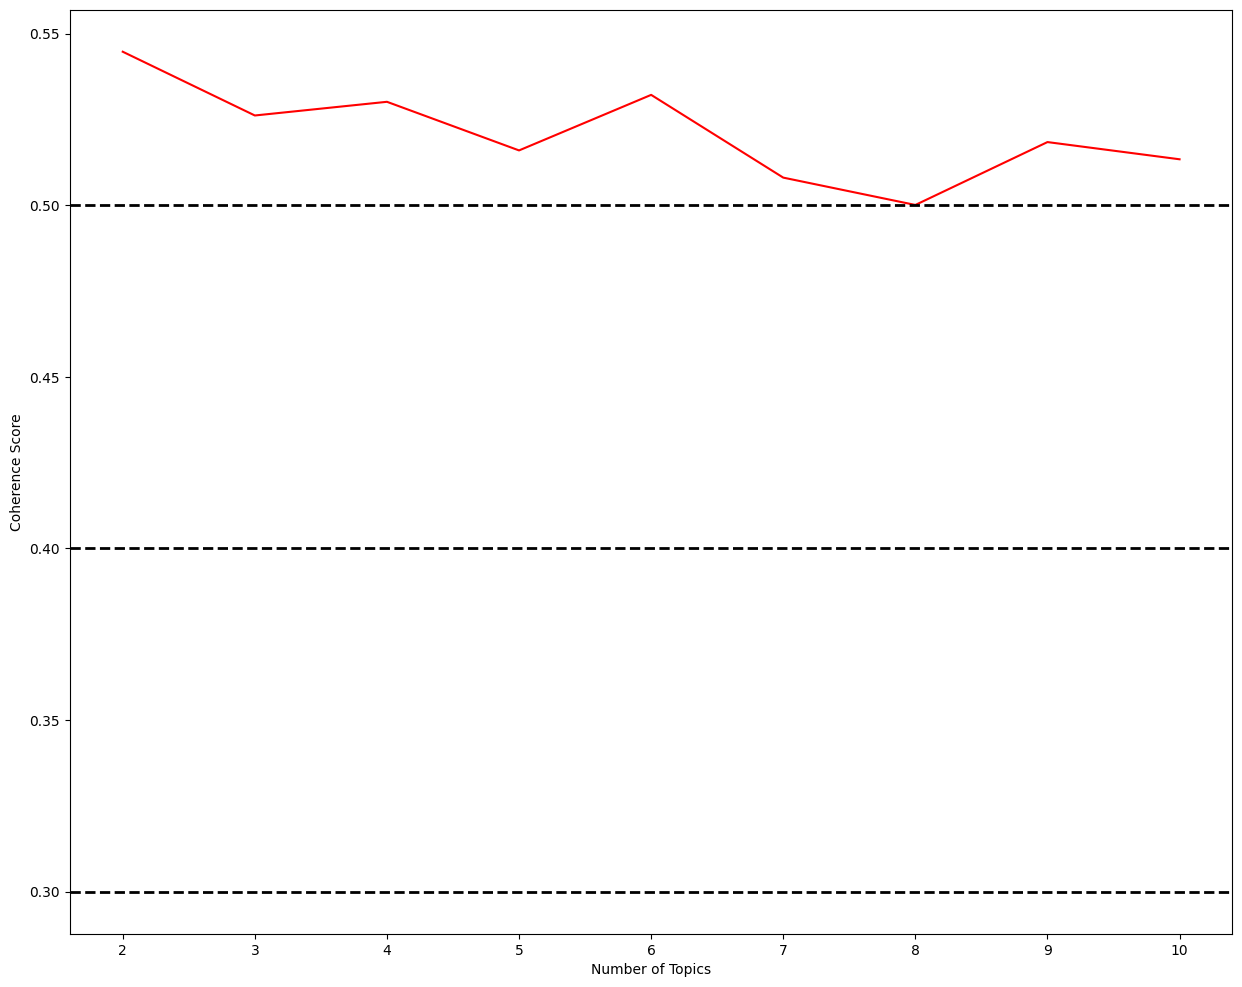


DF NAME: df_neg



  0%|                                                                                            | 0/9 [00:00<?, ?it/s]


MODEL: LSI - NUMBER OF TOPICS: 2


 11%|█████████▎                                                                          | 1/9 [00:10<01:22, 10.34s/it]

Topic #1:
0.736*"I" + 0.426*"room" + 0.222*"hotel" + 0.137*"staff" + 0.131*"check" + 0.121*"stay" + 0.093*"go" + 0.081*"get" + 0.077*"night" + 0.076*"would" + 0.075*"ask" + 0.075*"even" + 0.075*"time" + 0.073*"book" + 0.071*"one" + 0.066*"say" + 0.064*"small" + 0.064*"wait" + 0.062*"tell" + 0.061*"service"

Topic #2:
0.748*"room" + -0.558*"I" + 0.160*"hotel" + 0.103*"small" + 0.074*"bathroom" + 0.073*"stay" + 0.066*"good" + 0.059*"bed" + -0.057*"wait" + 0.055*"clean" + 0.055*"door" + 0.054*"would" + -0.053*"tell" + 0.052*"bad" + -0.049*"mind" + 0.047*"floor" + 0.047*"get" + 0.046*"could" + 0.046*"location" + 0.045*"smell"

--------------------------------------------------

MODEL: LSI - NUMBER OF TOPICS: 3


 22%|██████████████████▋                                                                 | 2/9 [00:21<01:14, 10.58s/it]

Topic #1:
0.736*"I" + 0.426*"room" + 0.222*"hotel" + 0.137*"staff" + 0.131*"check" + 0.121*"stay" + 0.093*"go" + 0.081*"get" + 0.077*"night" + 0.076*"would" + 0.075*"ask" + 0.075*"even" + 0.075*"time" + 0.073*"book" + 0.071*"one" + 0.066*"say" + 0.064*"small" + 0.064*"wait" + 0.062*"tell" + 0.061*"service"

Topic #2:
0.748*"room" + -0.558*"I" + 0.160*"hotel" + 0.103*"small" + 0.074*"bathroom" + 0.073*"stay" + 0.066*"good" + 0.059*"bed" + -0.057*"wait" + 0.055*"clean" + 0.055*"door" + 0.054*"would" + -0.053*"tell" + 0.052*"bad" + -0.049*"mind" + 0.047*"floor" + 0.047*"get" + 0.046*"could" + 0.046*"location" + 0.045*"smell"

Topic #3:
0.816*"hotel" + -0.322*"room" + 0.209*"staff" + -0.185*"I" + 0.125*"check" + 0.096*"wait" + -0.084*"night" + 0.083*"need" + 0.074*"star" + 0.070*"pm" + 0.070*"stay" + 0.065*"good" + -0.064*"move" + 0.062*"go" + 0.062*"one" + 0.059*"recommend" + 0.058*"well" + 0.055*"old" + 0.055*"tell" + -0.054*"morning"

--------------------------------------------------



 33%|████████████████████████████                                                        | 3/9 [00:31<01:03, 10.61s/it]

Topic #1:
0.736*"I" + 0.426*"room" + 0.222*"hotel" + 0.137*"staff" + 0.131*"check" + 0.121*"stay" + 0.093*"go" + 0.081*"get" + 0.077*"night" + 0.076*"would" + 0.075*"ask" + 0.075*"even" + 0.075*"time" + 0.073*"book" + 0.071*"one" + 0.066*"say" + 0.064*"small" + 0.064*"wait" + 0.062*"tell" + 0.061*"service"

Topic #2:
0.748*"room" + -0.558*"I" + 0.160*"hotel" + 0.103*"small" + 0.074*"bathroom" + 0.073*"stay" + 0.066*"good" + 0.059*"bed" + -0.057*"wait" + 0.055*"clean" + 0.055*"door" + 0.054*"would" + -0.053*"tell" + 0.052*"bad" + -0.049*"mind" + 0.047*"floor" + 0.047*"get" + 0.046*"could" + 0.046*"location" + 0.045*"smell"

Topic #3:
-0.816*"hotel" + 0.322*"room" + -0.209*"staff" + 0.185*"I" + -0.125*"check" + -0.096*"wait" + 0.084*"night" + -0.083*"need" + -0.074*"star" + -0.070*"pm" + -0.070*"stay" + -0.065*"good" + 0.064*"move" + -0.062*"go" + -0.062*"one" + -0.059*"recommend" + -0.058*"well" + -0.055*"old" + -0.055*"tell" + 0.054*"morning"

Topic #4:
0.323*"stay" + 0.291*"bed" + -0.

 44%|█████████████████████████████████████▎                                              | 4/9 [00:42<00:53, 10.72s/it]

Topic #1:
0.736*"I" + 0.426*"room" + 0.222*"hotel" + 0.137*"staff" + 0.131*"check" + 0.121*"stay" + 0.093*"go" + 0.081*"get" + 0.077*"night" + 0.076*"would" + 0.075*"ask" + 0.075*"even" + 0.075*"time" + 0.073*"book" + 0.071*"one" + 0.066*"say" + 0.064*"small" + 0.064*"wait" + 0.062*"tell" + 0.061*"service"

Topic #2:
-0.748*"room" + 0.558*"I" + -0.160*"hotel" + -0.103*"small" + -0.074*"bathroom" + -0.073*"stay" + -0.066*"good" + -0.059*"bed" + 0.057*"wait" + -0.055*"clean" + -0.055*"door" + -0.054*"would" + 0.053*"tell" + -0.052*"bad" + 0.049*"mind" + -0.047*"floor" + -0.047*"get" + -0.046*"could" + -0.046*"location" + -0.045*"smell"

Topic #3:
0.816*"hotel" + -0.322*"room" + 0.209*"staff" + -0.185*"I" + 0.125*"check" + 0.096*"wait" + -0.084*"night" + 0.083*"need" + 0.074*"star" + 0.070*"pm" + 0.070*"stay" + 0.065*"good" + -0.064*"move" + 0.062*"go" + 0.062*"one" + 0.059*"recommend" + 0.058*"well" + 0.055*"old" + 0.055*"tell" + -0.054*"morning"

Topic #4:
-0.323*"stay" + -0.291*"bed" +

 56%|██████████████████████████████████████████████▋                                     | 5/9 [00:53<00:43, 10.86s/it]

Topic #1:
0.736*"I" + 0.426*"room" + 0.222*"hotel" + 0.137*"staff" + 0.131*"check" + 0.121*"stay" + 0.093*"go" + 0.081*"get" + 0.077*"night" + 0.076*"would" + 0.075*"ask" + 0.075*"even" + 0.075*"time" + 0.073*"book" + 0.071*"one" + 0.066*"say" + 0.064*"small" + 0.064*"wait" + 0.062*"tell" + 0.061*"service"

Topic #2:
0.748*"room" + -0.558*"I" + 0.160*"hotel" + 0.103*"small" + 0.074*"bathroom" + 0.073*"stay" + 0.066*"good" + 0.059*"bed" + -0.057*"wait" + 0.055*"clean" + 0.055*"door" + 0.054*"would" + -0.053*"tell" + 0.052*"bad" + -0.049*"mind" + 0.047*"floor" + 0.047*"get" + 0.046*"could" + 0.046*"location" + 0.045*"smell"

Topic #3:
-0.816*"hotel" + 0.322*"room" + -0.209*"staff" + 0.185*"I" + -0.125*"check" + -0.096*"wait" + 0.084*"night" + -0.083*"need" + -0.074*"star" + -0.070*"pm" + -0.070*"stay" + -0.065*"good" + 0.064*"move" + -0.062*"go" + -0.062*"one" + -0.059*"recommend" + -0.058*"well" + -0.055*"old" + -0.055*"tell" + 0.054*"morning"

Topic #4:
-0.323*"stay" + -0.291*"bed" + 0

 67%|████████████████████████████████████████████████████████                            | 6/9 [01:04<00:32, 10.97s/it]

Topic #1:
0.736*"I" + 0.426*"room" + 0.222*"hotel" + 0.137*"staff" + 0.131*"check" + 0.121*"stay" + 0.093*"go" + 0.081*"get" + 0.077*"night" + 0.076*"would" + 0.075*"ask" + 0.075*"even" + 0.075*"time" + 0.073*"book" + 0.071*"one" + 0.066*"say" + 0.064*"small" + 0.064*"wait" + 0.062*"tell" + 0.061*"service"

Topic #2:
0.748*"room" + -0.558*"I" + 0.160*"hotel" + 0.103*"small" + 0.074*"bathroom" + 0.073*"stay" + 0.066*"good" + 0.059*"bed" + -0.057*"wait" + 0.055*"clean" + 0.055*"door" + 0.054*"would" + -0.053*"tell" + 0.052*"bad" + -0.049*"mind" + 0.047*"floor" + 0.047*"get" + 0.046*"could" + 0.046*"location" + 0.045*"smell"

Topic #3:
-0.816*"hotel" + 0.322*"room" + -0.209*"staff" + 0.185*"I" + -0.125*"check" + -0.096*"wait" + 0.084*"night" + -0.083*"need" + -0.074*"star" + -0.070*"pm" + -0.070*"stay" + -0.065*"good" + 0.064*"move" + -0.062*"go" + -0.062*"one" + -0.059*"recommend" + -0.058*"well" + -0.055*"old" + -0.055*"tell" + 0.054*"morning"

Topic #4:
0.323*"stay" + 0.291*"bed" + -0.

 78%|█████████████████████████████████████████████████████████████████▎                  | 7/9 [01:16<00:22, 11.18s/it]

Topic #1:
0.736*"I" + 0.426*"room" + 0.222*"hotel" + 0.137*"staff" + 0.131*"check" + 0.121*"stay" + 0.093*"go" + 0.081*"get" + 0.077*"night" + 0.076*"would" + 0.075*"ask" + 0.075*"even" + 0.075*"time" + 0.073*"book" + 0.071*"one" + 0.066*"say" + 0.064*"small" + 0.064*"wait" + 0.062*"tell" + 0.061*"service"

Topic #2:
-0.748*"room" + 0.558*"I" + -0.160*"hotel" + -0.103*"small" + -0.074*"bathroom" + -0.073*"stay" + -0.066*"good" + -0.059*"bed" + 0.057*"wait" + -0.055*"clean" + -0.055*"door" + -0.054*"would" + 0.053*"tell" + -0.052*"bad" + 0.049*"mind" + -0.047*"floor" + -0.047*"get" + -0.046*"could" + -0.046*"location" + -0.045*"smell"

Topic #3:
0.816*"hotel" + -0.322*"room" + 0.209*"staff" + -0.185*"I" + 0.125*"check" + 0.096*"wait" + -0.084*"night" + 0.083*"need" + 0.074*"star" + 0.070*"pm" + 0.070*"stay" + 0.065*"good" + -0.064*"move" + 0.062*"go" + 0.062*"one" + 0.059*"recommend" + 0.058*"well" + 0.055*"old" + 0.055*"tell" + -0.054*"morning"

Topic #4:
-0.323*"stay" + -0.291*"bed" +

 89%|██████████████████████████████████████████████████████████████████████████▋         | 8/9 [01:28<00:11, 11.33s/it]

Topic #1:
0.736*"I" + 0.426*"room" + 0.222*"hotel" + 0.137*"staff" + 0.131*"check" + 0.121*"stay" + 0.093*"go" + 0.081*"get" + 0.077*"night" + 0.076*"would" + 0.075*"ask" + 0.075*"even" + 0.075*"time" + 0.073*"book" + 0.071*"one" + 0.066*"say" + 0.064*"small" + 0.064*"wait" + 0.062*"tell" + 0.061*"service"

Topic #2:
0.748*"room" + -0.558*"I" + 0.160*"hotel" + 0.103*"small" + 0.074*"bathroom" + 0.073*"stay" + 0.066*"good" + 0.059*"bed" + -0.057*"wait" + 0.055*"clean" + 0.055*"door" + 0.054*"would" + -0.053*"tell" + 0.052*"bad" + -0.049*"mind" + 0.047*"floor" + 0.047*"get" + 0.046*"could" + 0.046*"location" + 0.045*"smell"

Topic #3:
-0.816*"hotel" + 0.322*"room" + -0.209*"staff" + 0.185*"I" + -0.125*"check" + -0.096*"wait" + 0.084*"night" + -0.083*"need" + -0.074*"star" + -0.070*"pm" + -0.070*"stay" + -0.065*"good" + 0.064*"move" + -0.062*"go" + -0.062*"one" + -0.059*"recommend" + -0.058*"well" + -0.055*"old" + -0.055*"tell" + 0.054*"morning"

Topic #4:
-0.323*"stay" + -0.291*"bed" + 0

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [01:39<00:00, 11.09s/it]


Topic #1:
0.736*"I" + 0.426*"room" + 0.222*"hotel" + 0.137*"staff" + 0.131*"check" + 0.121*"stay" + 0.093*"go" + 0.081*"get" + 0.077*"night" + 0.076*"would" + 0.075*"ask" + 0.075*"even" + 0.075*"time" + 0.073*"book" + 0.071*"one" + 0.066*"say" + 0.064*"small" + 0.064*"wait" + 0.062*"tell" + 0.061*"service"

Topic #2:
-0.748*"room" + 0.558*"I" + -0.160*"hotel" + -0.103*"small" + -0.074*"bathroom" + -0.073*"stay" + -0.066*"good" + -0.059*"bed" + 0.057*"wait" + -0.055*"clean" + -0.055*"door" + -0.054*"would" + 0.053*"tell" + -0.052*"bad" + 0.049*"mind" + -0.047*"floor" + -0.047*"get" + -0.046*"could" + -0.046*"location" + -0.045*"smell"

Topic #3:
0.816*"hotel" + -0.322*"room" + 0.209*"staff" + -0.185*"I" + 0.125*"check" + 0.096*"wait" + -0.084*"night" + 0.083*"need" + 0.074*"star" + 0.070*"pm" + 0.070*"stay" + 0.065*"good" + -0.064*"move" + 0.062*"go" + 0.062*"one" + 0.059*"recommend" + 0.058*"well" + 0.055*"old" + 0.055*"tell" + -0.054*"morning"

Topic #4:
-0.323*"stay" + -0.291*"bed" +

  0%|                                                                                            | 0/9 [00:00<?, ?it/s]


MODEL: LDA - NUMBER OF TOPICS: 2


 11%|█████████▎                                                                          | 1/9 [00:04<00:32,  4.07s/it]

Topic #1:
0.087*"room" + 0.046*"I" + 0.041*"hotel" + 0.028*"staff" + 0.027*"small" + 0.022*"check" + 0.017*"good" + 0.015*"bad" + 0.014*"stay" + 0.014*"well" + 0.014*"clean" + 0.014*"get" + 0.013*"place" + 0.013*"location" + 0.013*"time" + 0.013*"breakfast" + 0.012*"service" + 0.012*"sleep" + 0.011*"like" + 0.011*"toilet"

Topic #2:
0.087*"I" + 0.068*"room" + 0.036*"hotel" + 0.023*"stay" + 0.021*"staff" + 0.020*"bed" + 0.018*"get" + 0.015*"check" + 0.014*"even" + 0.013*"night" + 0.013*"dirty" + 0.012*"would" + 0.012*"clean" + 0.012*"time" + 0.012*"book" + 0.012*"go" + 0.011*"good" + 0.011*"need" + 0.010*"reception" + 0.010*"one"

--------------------------------------------------

MODEL: LDA - NUMBER OF TOPICS: 3


 22%|██████████████████▋                                                                 | 2/9 [00:07<00:26,  3.82s/it]

Topic #1:
0.075*"I" + 0.037*"room" + 0.027*"get" + 0.025*"hotel" + 0.023*"staff" + 0.022*"check" + 0.021*"bed" + 0.019*"clean" + 0.018*"breakfast" + 0.017*"stay" + 0.017*"nothing" + 0.016*"good" + 0.015*"place" + 0.015*"toilet" + 0.013*"one" + 0.012*"guest" + 0.012*"time" + 0.012*"really" + 0.012*"bad" + 0.011*"area"

Topic #2:
0.103*"I" + 0.064*"room" + 0.032*"hotel" + 0.029*"staff" + 0.025*"stay" + 0.022*"would" + 0.018*"night" + 0.015*"well" + 0.014*"get" + 0.013*"bad" + 0.013*"service" + 0.013*"even" + 0.012*"dirty" + 0.012*"go" + 0.012*"place" + 0.012*"day" + 0.011*"bit" + 0.010*"good" + 0.010*"need" + 0.010*"make"

Topic #3:
0.105*"room" + 0.049*"hotel" + 0.045*"I" + 0.025*"small" + 0.022*"check" + 0.020*"staff" + 0.018*"time" + 0.017*"stay" + 0.016*"bed" + 0.014*"good" + 0.013*"location" + 0.013*"book" + 0.013*"like" + 0.013*"clean" + 0.012*"bathroom" + 0.012*"get" + 0.012*"could" + 0.011*"one" + 0.011*"smell" + 0.010*"even"

--------------------------------------------------

M

 33%|████████████████████████████                                                        | 3/9 [00:11<00:21,  3.58s/it]

Topic #1:
0.090*"room" + 0.076*"I" + 0.048*"hotel" + 0.025*"staff" + 0.020*"check" + 0.019*"good" + 0.019*"clean" + 0.016*"stay" + 0.014*"small" + 0.014*"bad" + 0.013*"location" + 0.013*"time" + 0.013*"bed" + 0.013*"dirty" + 0.013*"go" + 0.013*"even" + 0.012*"well" + 0.011*"get" + 0.011*"service" + 0.011*"nothing"

Topic #2:
0.088*"room" + 0.068*"I" + 0.027*"night" + 0.027*"stay" + 0.025*"would" + 0.023*"small" + 0.022*"check" + 0.018*"get" + 0.017*"hotel" + 0.014*"could" + 0.014*"work" + 0.014*"staff" + 0.013*"ask" + 0.012*"bed" + 0.011*"really" + 0.011*"day" + 0.011*"time" + 0.011*"also" + 0.011*"book" + 0.011*"breakfast"

Topic #3:
0.075*"I" + 0.029*"staff" + 0.027*"get" + 0.025*"stay" + 0.022*"water" + 0.021*"bed" + 0.020*"time" + 0.019*"like" + 0.018*"hotel" + 0.017*"one" + 0.017*"day" + 0.017*"make" + 0.016*"floor" + 0.014*"friendly" + 0.013*"toilet" + 0.013*"room" + 0.013*"even" + 0.012*"check" + 0.012*"shower" + 0.011*"guest"

Topic #4:
0.063*"hotel" + 0.053*"I" + 0.048*"room" 

 44%|█████████████████████████████████████▎                                              | 4/9 [00:14<00:17,  3.46s/it]

Topic #1:
0.043*"room" + 0.033*"I" + 0.031*"staff" + 0.031*"check" + 0.026*"stay" + 0.026*"dirty" + 0.025*"hotel" + 0.021*"night" + 0.020*"bad" + 0.018*"go" + 0.017*"bed" + 0.016*"time" + 0.016*"sleep" + 0.015*"also" + 0.014*"experience" + 0.014*"place" + 0.013*"get" + 0.013*"location" + 0.013*"make" + 0.013*"little"

Topic #2:
0.101*"room" + 0.085*"I" + 0.041*"hotel" + 0.019*"check" + 0.018*"time" + 0.017*"get" + 0.017*"need" + 0.016*"stay" + 0.016*"staff" + 0.014*"bed" + 0.014*"bad" + 0.013*"even" + 0.013*"go" + 0.013*"could" + 0.012*"smell" + 0.011*"night" + 0.011*"would" + 0.011*"bathroom" + 0.010*"take" + 0.010*"one"

Topic #3:
0.051*"I" + 0.044*"get" + 0.036*"room" + 0.027*"breakfast" + 0.027*"toilet" + 0.023*"good" + 0.022*"water" + 0.021*"pool" + 0.021*"could" + 0.019*"staff" + 0.015*"check" + 0.014*"clean" + 0.013*"floor" + 0.013*"area" + 0.012*"well" + 0.012*"like" + 0.012*"would" + 0.012*"stay" + 0.011*"bed" + 0.011*"use"

Topic #4:
0.109*"I" + 0.042*"hotel" + 0.039*"room" +

 56%|██████████████████████████████████████████████▋                                     | 5/9 [00:17<00:13,  3.38s/it]

Topic #1:
0.132*"I" + 0.043*"hotel" + 0.040*"check" + 0.035*"room" + 0.028*"staff" + 0.018*"place" + 0.015*"go" + 0.015*"time" + 0.014*"really" + 0.014*"stay" + 0.014*"wait" + 0.014*"mind" + 0.013*"take" + 0.013*"breakfast" + 0.013*"small" + 0.012*"bad" + 0.012*"even" + 0.011*"good" + 0.011*"price" + 0.011*"ask"

Topic #2:
0.079*"room" + 0.043*"small" + 0.042*"staff" + 0.029*"service" + 0.023*"lack" + 0.023*"cleanliness" + 0.018*"location" + 0.017*"would" + 0.017*"take" + 0.017*"hour" + 0.017*"pool" + 0.017*"poor" + 0.016*"bathroom" + 0.014*"check" + 0.014*"go" + 0.014*"breakfast" + 0.014*"water" + 0.012*"reception" + 0.012*"hot" + 0.012*"back"

Topic #3:
0.084*"room" + 0.072*"I" + 0.037*"staff" + 0.028*"clean" + 0.028*"bed" + 0.024*"hotel" + 0.023*"good" + 0.020*"time" + 0.018*"need" + 0.017*"small" + 0.016*"get" + 0.014*"bad" + 0.014*"even" + 0.012*"dirty" + 0.012*"stay" + 0.012*"area" + 0.012*"would" + 0.011*"bathroom" + 0.011*"service" + 0.011*"nothing"

Topic #4:
0.088*"I" + 0.066

 67%|████████████████████████████████████████████████████████                            | 6/9 [00:20<00:09,  3.33s/it]

Topic #1:
0.096*"I" + 0.073*"room" + 0.030*"staff" + 0.028*"hotel" + 0.028*"stay" + 0.027*"get" + 0.022*"service" + 0.017*"small" + 0.016*"one" + 0.016*"clean" + 0.014*"even" + 0.013*"like" + 0.013*"bed" + 0.012*"go" + 0.012*"well" + 0.011*"hour" + 0.011*"good" + 0.011*"check" + 0.010*"would" + 0.010*"feel"

Topic #2:
0.093*"room" + 0.047*"I" + 0.035*"staff" + 0.031*"clean" + 0.028*"bed" + 0.025*"small" + 0.025*"dirty" + 0.021*"bad" + 0.017*"check" + 0.017*"shower" + 0.015*"get" + 0.015*"take" + 0.015*"ask" + 0.014*"air" + 0.013*"hotel" + 0.013*"would" + 0.013*"give" + 0.013*"never" + 0.011*"place" + 0.011*"sleep"

Topic #3:
0.100*"I" + 0.028*"room" + 0.028*"check" + 0.028*"would" + 0.027*"hotel" + 0.024*"guest" + 0.020*"bed" + 0.019*"stay" + 0.019*"breakfast" + 0.017*"water" + 0.017*"get" + 0.016*"staff" + 0.015*"place" + 0.015*"look" + 0.014*"door" + 0.014*"need" + 0.014*"one" + 0.012*"take" + 0.012*"request" + 0.012*"floor"

Topic #4:
0.083*"room" + 0.070*"I" + 0.040*"hotel" + 0.033

 78%|█████████████████████████████████████████████████████████████████▎                  | 7/9 [00:23<00:06,  3.30s/it]

Topic #1:
0.071*"hotel" + 0.046*"room" + 0.030*"place" + 0.028*"I" + 0.024*"check" + 0.024*"good" + 0.020*"toilet" + 0.020*"get" + 0.019*"bathroom" + 0.018*"clean" + 0.018*"dirty" + 0.016*"bed" + 0.016*"work" + 0.016*"bad" + 0.016*"location" + 0.016*"bit" + 0.015*"time" + 0.015*"even" + 0.015*"small" + 0.014*"need"

Topic #2:
0.083*"room" + 0.036*"bed" + 0.032*"stay" + 0.023*"hotel" + 0.023*"I" + 0.022*"staff" + 0.022*"time" + 0.021*"night" + 0.018*"day" + 0.017*"one" + 0.016*"clean" + 0.015*"experience" + 0.015*"small" + 0.014*"good" + 0.013*"well" + 0.013*"find" + 0.012*"go" + 0.012*"hour" + 0.012*"service" + 0.012*"book"

Topic #3:
0.112*"I" + 0.071*"room" + 0.036*"staff" + 0.024*"get" + 0.021*"check" + 0.017*"small" + 0.016*"make" + 0.015*"go" + 0.015*"hotel" + 0.014*"could" + 0.014*"even" + 0.014*"bed" + 0.014*"nothing" + 0.014*"stay" + 0.014*"good" + 0.012*"night" + 0.012*"service" + 0.011*"time" + 0.011*"door" + 0.011*"request"

Topic #4:
0.053*"room" + 0.023*"staff" + 0.023*"wa

 89%|██████████████████████████████████████████████████████████████████████████▋         | 8/9 [00:27<00:03,  3.26s/it]

Topic #1:
0.088*"hotel" + 0.035*"staff" + 0.033*"room" + 0.028*"check" + 0.025*"never" + 0.023*"I" + 0.023*"could" + 0.023*"hair" + 0.020*"star" + 0.020*"time" + 0.020*"money" + 0.015*"get" + 0.015*"area" + 0.015*"well" + 0.015*"need" + 0.015*"night" + 0.015*"guest" + 0.015*"even" + 0.013*"stay" + 0.013*"dirty"

Topic #2:
0.061*"I" + 0.060*"hotel" + 0.046*"room" + 0.031*"stay" + 0.028*"bed" + 0.023*"staff" + 0.022*"get" + 0.021*"well" + 0.020*"location" + 0.019*"would" + 0.017*"smell" + 0.017*"good" + 0.016*"breakfast" + 0.015*"could" + 0.014*"day" + 0.014*"work" + 0.014*"place" + 0.014*"old" + 0.013*"water" + 0.013*"night"

Topic #3:
0.061*"staff" + 0.051*"hotel" + 0.039*"room" + 0.033*"I" + 0.026*"bad" + 0.020*"clean" + 0.020*"good" + 0.018*"smell" + 0.018*"cleanliness" + 0.017*"place" + 0.016*"bed" + 0.016*"dirty" + 0.016*"old" + 0.016*"water" + 0.016*"bathroom" + 0.016*"shower" + 0.016*"nothing" + 0.014*"breakfast" + 0.014*"door" + 0.014*"helpful"

Topic #4:
0.105*"room" + 0.034*"s

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:30<00:00,  3.38s/it]

Topic #1:
0.105*"room" + 0.033*"staff" + 0.033*"get" + 0.033*"small" + 0.029*"stay" + 0.029*"price" + 0.026*"check" + 0.026*"make" + 0.022*"sleep" + 0.022*"little" + 0.022*"food" + 0.018*"I" + 0.018*"feel" + 0.018*"time" + 0.018*"even" + 0.015*"experience" + 0.015*"really" + 0.015*"change" + 0.015*"early" + 0.015*"pm"

Topic #2:
0.085*"room" + 0.031*"hotel" + 0.031*"water" + 0.031*"breakfast" + 0.028*"stay" + 0.028*"facility" + 0.025*"work" + 0.021*"give" + 0.018*"I" + 0.018*"location" + 0.018*"pool" + 0.018*"day" + 0.018*"ok" + 0.015*"check" + 0.015*"old" + 0.015*"make" + 0.015*"bit" + 0.015*"one" + 0.015*"toilet" + 0.012*"good"

Topic #3:
0.094*"room" + 0.075*"I" + 0.071*"hotel" + 0.027*"stay" + 0.020*"book" + 0.018*"go" + 0.018*"staff" + 0.016*"get" + 0.015*"check" + 0.013*"one" + 0.013*"night" + 0.013*"recommend" + 0.012*"would" + 0.011*"good" + 0.011*"place" + 0.010*"clean" + 0.010*"area" + 0.010*"time" + 0.010*"star" + 0.010*"even"

Topic #4:
0.128*"room" + 0.037*"I" + 0.028*"nig

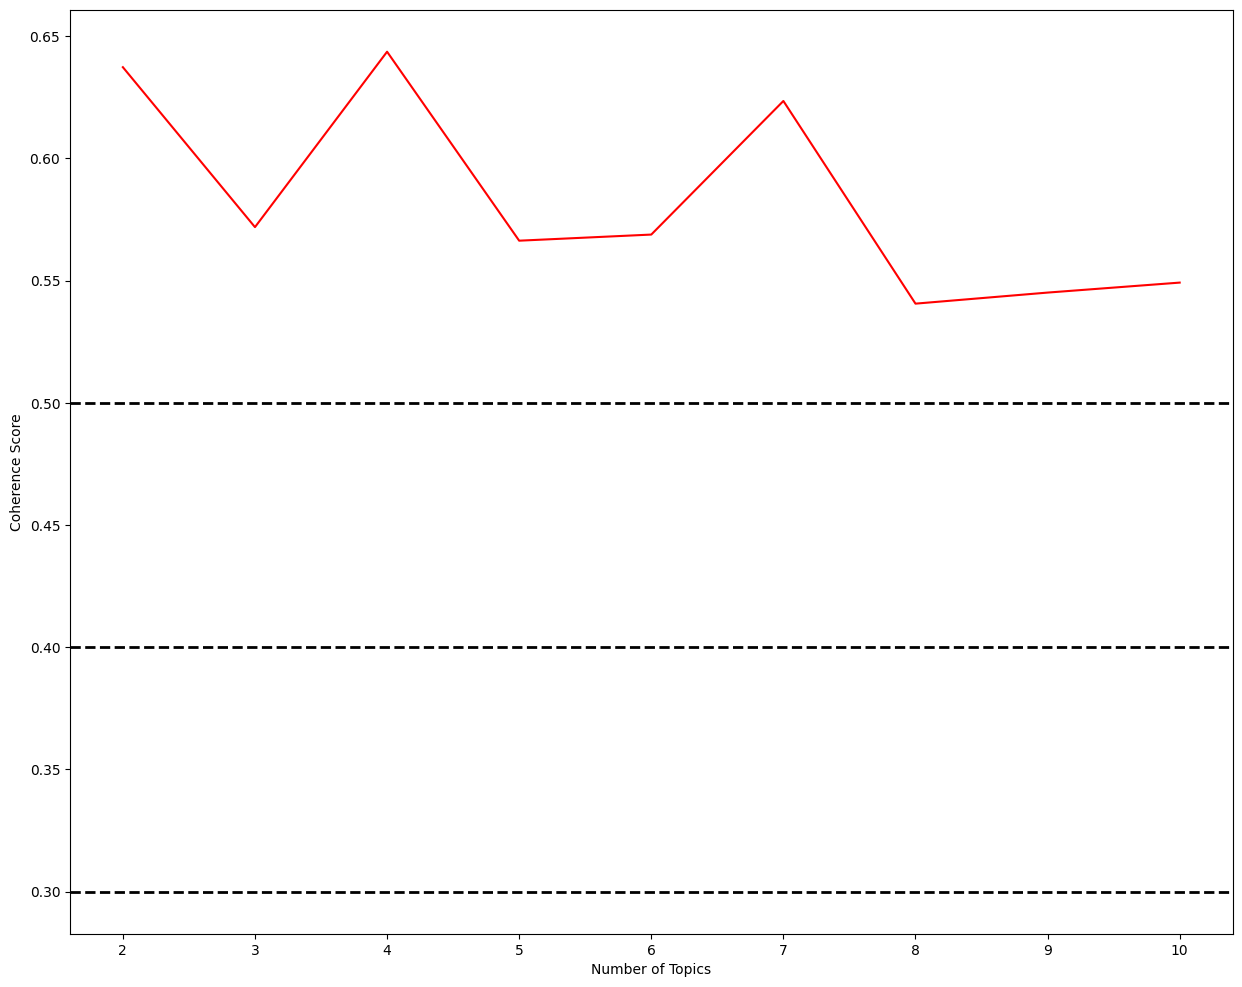

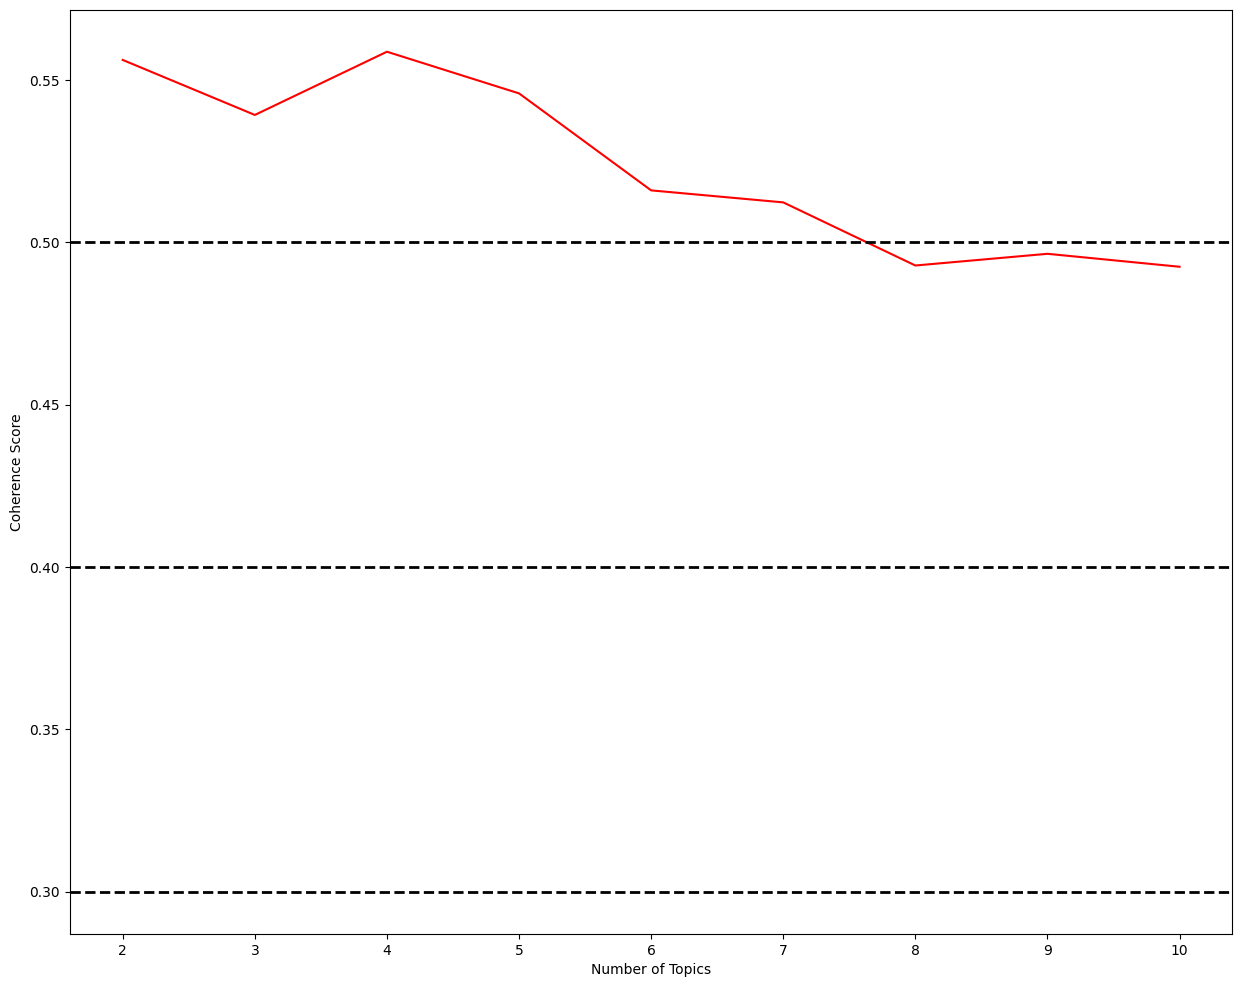

In [10]:
# Calculate coherence scores for each model
target_text = "review_cleaned_v1"

overall_coherence_df = pd.DataFrame() # df to store coherence_df
model_topic_info_list = []  # List to store model_topic_info

for i, df_set in enumerate(df_sets):
    
    print("\nDF NAME: {}\n".format(df_names[i]))

    coherence_df, model_topic_info = topic_model_coherence_plot(df_set, df_names[i], target_text, MODEL_NAMES, START_TOPIC_COUNT, END_TOPIC_COUNT)
    overall_coherence_df = pd.concat([overall_coherence_df, coherence_df], axis=0) # Concatenate to overall_coherence_df
    model_topic_info_list.append(model_topic_info) # Store model_topic_info in a list

In [11]:
# Print all models' coherence scores
overall_coherence_df

,Model Name,Number of Topics,Coherence Score,df_name
0,LSI,2,0.547662,df_pos
1,LSI,3,0.541924,df_pos
2,LSI,4,0.551123,df_pos
3,LSI,5,0.521539,df_pos
4,LSI,6,0.535197,df_pos
5,LSI,7,0.534308,df_pos
6,LSI,8,0.514864,df_pos
7,LSI,9,0.538127,df_pos
8,LSI,10,0.539986,df_pos
0,LDA,2,0.544739,df_pos


In [12]:
# Store coherence scores of all models into "overall_coherence_df", sort by "df_name" and "Coherence Score"
overall_coherence_df = overall_coherence_df.sort_values(["df_name", "Coherence Score"], ascending=False).reset_index(drop=True)
#overall_coherence_df

# Find best model for each df
overall_coherence_best_df = overall_coherence_df.loc[overall_coherence_df.groupby("df_name")["Coherence Score"].idxmax()].reset_index(drop=True)
overall_coherence_best_df

,Model Name,Number of Topics,Coherence Score,df_name
0,LSI,4,0.643626,df_neg
1,LSI,4,0.551123,df_pos


In [13]:
# Print topics of best model
print_best_model_topics(overall_coherence_best_df, model_topic_info_list)


DF NAME: df_neg
MODEL: LSI - NUMBER OF TOPICS: 4

Topic 1: I, room, hotel, staff, check, stay, go, get, night, would

Topic 2: room, I, hotel, small, bathroom, stay, good, bed, wait, clean

Topic 3: hotel, room, staff, I, check, wait, night, need, star, pm

Topic 4: stay, bed, room, get, place, hotel, clean, like, well, water

----------


DF NAME: df_pos
MODEL: LSI - NUMBER OF TOPICS: 4

Topic 1: room, I, hotel, stay, staff, good, location, clean, great, check

Topic 2: I, room, good, location, clean, hotel, small, stay, staff, great

Topic 3: room, hotel, good, location, stay, staff, small, great, place, breakfast

Topic 4: good, hotel, location, stay, I, clean, place, day, staff, well

----------



In [14]:
end_time = datetime.now()
print("Text processing ended at {}".format(end_time))
print("Text processing spent {}".format(end_time - start_time))

Text processing ended at 2024-06-26 01:20:55.948642
Text processing spent 0:10:41.476417
